In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

# 1.Data preprocessing

In [2]:
def preprocess(array):
    """
    Normalize arrays and convert them to the appropriate format
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

def noise(array):
    """
    Add random noise to each image in the array
    """

    noise_factor = 0.7
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

def display(array1, array2):
    """
    Let's display ten random images from the array
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2[:, :, 0])  # Take the first channel
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


# 2.Load training and test data

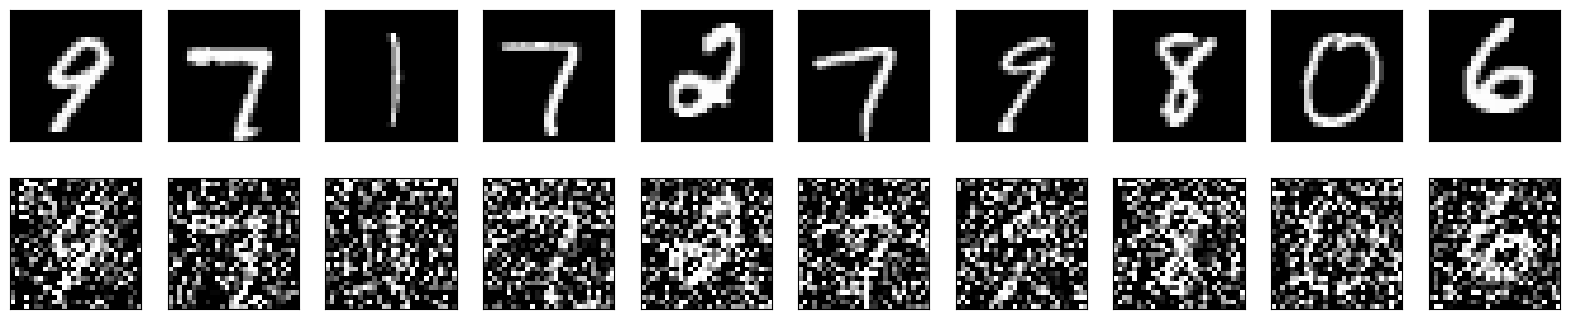

In [3]:
# Since we only need the images in the dataset for encoding and decoding, we will not use labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Image Normalization
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with noise added
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Displays the data to which noise was added and its version.
display(train_data, noisy_train_data)

# 3. Building Model

In [4]:
from tensorflow.keras import layers, Model

input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)

x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)

x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2D(1, (5, 5), activation="relu", padding="valid")(x)

# Output layer with sigmoid activation
decoded = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder model
autoencoder = Model(input, decoded)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856 

# 4.Training on the data

In [5]:
#A set of noisy training data is trained to reconstruct clean images or data.
history = autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/50
469/469 [==============================] - 18s 19ms/step - loss: 0.2013 - val_loss: 0.1554
Epoch 2/50
469/469 [==============================] - 8s 17ms/step - loss: 0.1419 - val_loss: 0.1305
Epoch 3/50
469/469 [==============================] - 9s 19ms/step - loss: 0.1285 - val_loss: 0.1253
Epoch 4/50
469/469 [==============================] - 8s 17ms/step - loss: 0.1237 - val_loss: 0.1216
Epoch 5/50
469/469 [==============================] - 8s 17ms/step - loss: 0.1210 - val_loss: 0.1195
Epoch 6/50
469/469 [==============================] - 8s 17ms/step - loss: 0.1189 - val_loss: 0.1182
Epoch 7/50
469/469 [==============================] - 8s 17ms/step - loss: 0.1175 - val_loss: 0.1171
Epoch 8/50
469/469 [==============================] - 8s 17ms/step - loss: 0.1163 - val_loss: 0.1169
Epoch 9/50
469/469 [==============================] - 9s 18ms/step - loss: 0.1154 - val_loss: 0.1161
Epoch 10/50
469/469 [==============================] - 8s 18ms/step - loss: 0.1146 - val_l

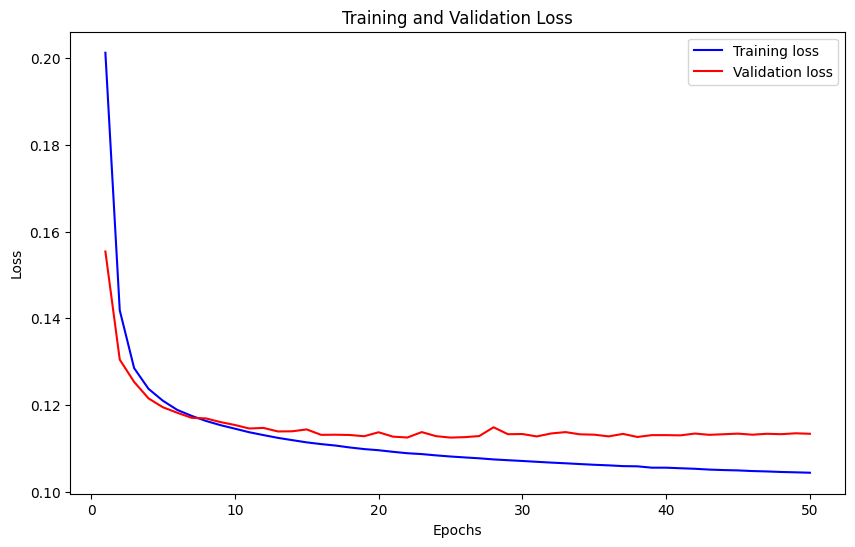

In [6]:
import matplotlib.pyplot as plt

# Extracting the training history of the loss and val_loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot a curve graph of loss and val_loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', label='Training loss')  # 使用'-'表示曲线
plt.plot(epochs, val_loss, 'r-', label='Validation loss')  # 使用'-'表示曲线
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 5.Predictions are now made based on the noise data

313/313 [==============================] - 1s 3ms/step


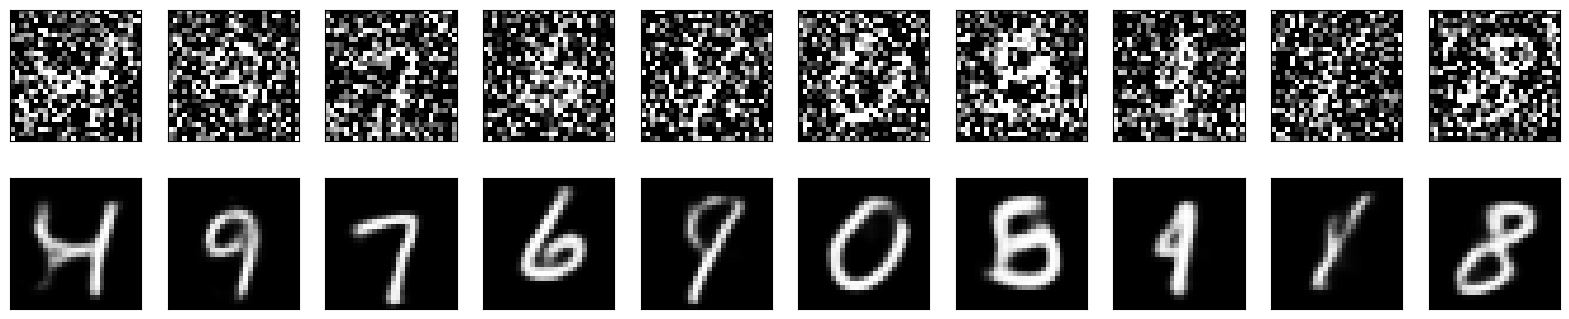

In [7]:
#Predictions are now made based on the noise data and the results of the autoencoder are displayed.
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)